In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

GOOGLE_API_KEY=os.getenv('GOOGLE_API_KEY')

In [2]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [3]:
model_name = "gemini-2.0-flash"
     

In [4]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """

In [5]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

In [6]:
from PIL import Image

import io
import os
import requests
from io import BytesIO
     

In [7]:
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [12]:

# @title Plotting Util

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)

    # Display the image
    img.show()

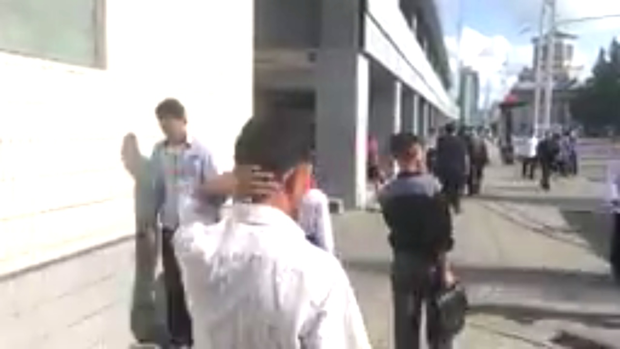

In [9]:
image = r"D:\My Hoa\work\VideoToAudioGuide\backend\frames\test1_20250227_095601\frame_0_00_50.jpg"

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

In [10]:
prompt = """
    Detect objects in the image. Return the output as a JSON list where each entry contains:
    - "box_2d": The 2D bounding box as [y_min, x_min, y_max, x_max].
    - "label": The name of the object (e.g., "bus", "car", "person").
    - "position": The relative position of the object in the image ("left", "right", "top", "bottom", "center", "top left", "bottom right", etc.).

    Ensure that:
    - "label" only contains the object's name, not its position.
    - "position" describes the object's placement.

    Do not return Markdown, explanations, or extra text. Only output valid JSON.
    """

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)
     

```json
[
  {"box_2d": [360, 598, 1000, 733], "label": "person", "position": "bottom left"},
  {"box_2d": [323, 263, 1000, 598], "label": "person", "position": "bottom center"},
  {"box_2d": [318, 228, 996, 313], "label": "person", "position": "left"},
  {"box_2d": [360, 749, 567, 787], "label": "person", "position": "center"},
  {"box_2d": [382, 701, 614, 755], "label": "person", "position": "center"},
  {"box_2d": [392, 833, 527, 868], "label": "person", "position": "right"},
  {"box_2d": [392, 870, 527, 896], "label": "person", "position": "right"},
  {"box_2d": [401, 911, 518, 934], "label": "person", "position": "right"}
]
```


(1024, 576)


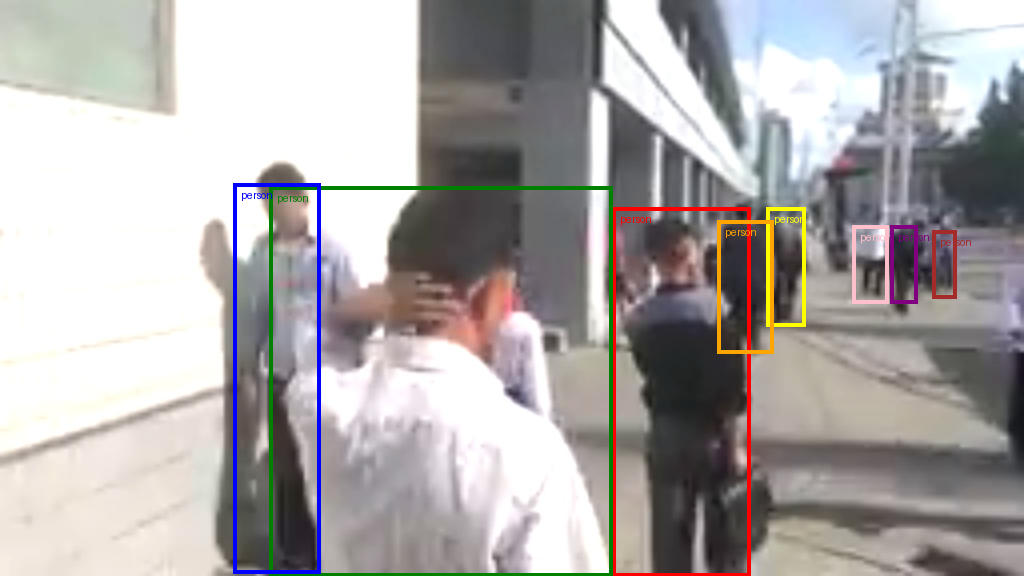

In [13]:
plot_bounding_boxes(im, response.text)
im